# 使用神经网络 图像识别入门
------

**CV，计算机视觉** 是一个应用广泛的方向，而且看起来也挺有趣，由于它的可视化和资料丰富，用来做机器学习的入门是再好不过的了。

我们这次分享的内容是使用现有的机器学习库，搭建神经网络，来做图像识别的应用。
这是一次应用层上的以项目驱动的入门经验分享，所以内容比较简单，
不涉及到神经网络的复杂原理，仅会从使用上介绍。

# 准备工作
------

## 数据
------

我们主要的目的是看看图像识别程序是怎么做出来的，所以即使前期的准备工作再重要，也不是这次分享的重点。

计算机视觉方向的数据集有很多，这些数据集就是有标注的图片，视频等，用来做监督学习。

图像识别方面的数据集有很多，比如 hello world 级别的 **MNIST** 手写数字数据集，数据量非常大的 **ImageNet** 数据集，**VOC PASCAL** 数据集等等。

## 环境
------

机器学习框架一般是以 CUDA 为后端，Python等语言作为前端，通过 C API 作为桥梁，用前端定义计算图，在后端执行并将结果返回前端。

虽然各大框架对Python的支持是最好的，但是也是可以使用其他语言来编程的，

比如**Torch**支持**lua**，**TensorFlow**还支持**C++,Java,JavaScript**，MXNET支持的更多。

python是一个动态类型的脚本语言，写起来简单，也是一个胶水语言，对C API支持的很好。

将计算密集型的工作交给CUDA，用python定义模型对于机器学习框架来说是很好的选择。

如果安装Python可以选择它的发行版，**Anaconda**。

Anaconda集成了很多有用的库，比如numpy，scipy，matpltlib等，而且conda自带包管理工具，很好用。

# 框架选择

![tf_vs_torch](./images/tf_vs_torch_r.jpg)

目前机器学习计算框架主要有谷歌开发的TensorFlow，Facebook开发的PyTorch和Caffe2，
亚马逊的MXNET等。之前比较火的Theano停止维护，Keras成为TensorFlow的核心包，
Caffe2的代码也已经开始并入PyTorch。机器学习框架的竞争可以说是十分激烈，也都越来越好用。

目前框架排名前两名是TensorFlow和PyTorch，下面说一下它们的特点。

## 静态计算图 vs 动态计算图

![静态计算图中的张量流](./images/tensorflow.gif)

在TensorFlow的1.4以前的版本，是纯静态图模式的。
要先写好所有的计算图，图中的节点只有形状，类型属性，而没有具体的数据，
也不需要每个节点都由人工去定义，框架可以推断出来运算结果的形状。
运行的话是生成静态的计算图后，再将数据传入进行计算。
形容一下写模型的过程，TensorFlow像是编译型的模板引擎，用Python的语法写模板，编译后的程序交给 CUDA 来执行，再将执行结果返回到前端，
和写前端模板一样。
TensorFlow静态图的优点就是可以方便地导入导出模型，方便部署。

1.5版本以后，Tensorflow也支持了动态图模式，Eager execution，像脚本语言一样，一行一行执行，这样对于调试模型非常方便。
目前为了调试方便，我写的的模型同时支持静态图和动态图，不过动态图只支持了预测和验证，训练还是静态图，因为动态图写训练非常复杂。

------

PyTorch是一个动态图框架，也是以张量`Tensor`为基础的一个框架，由于其动态图特点，没有TensorFlow那么多API要记，写起来也更简单。

TensorFlow写着不像Python，很麻烦，偏离了Python简单轻便的初衷，PyTorch写出来更简单更好看一些。

# 基础知识

## 张量 Tensor 和 变量 Variable

|     张量         |   形状  |   阶  |  别名  |
| :----------:     | :-----: | :---: | :----: |
|       5          |    []   |   0   |  标量 0-D Tensor  |
|   [1,2,3,4]      |   [5]   |   1   |  向量 1-D Tensor |
|  [[1,2], [3,4]]  |  [2,2]  |   2   |  矩阵 2-D Tensor |
|   [[[0,0,0]]]    | [1,1,3] |   3   |    3-D Tensor    |
|      ...         |         |   N   |    N-D Tensor    |

张量是标量，向量，矩阵的扩展。

## 框架中的Tensor

### TensorFlow

TensorFlow中的Tensor是不可变的，Variable是可变的(mutable) 。
Tensor一般是输入，或者经过计算得到的。
能用Tensor的地方，也能用Variable。

Variable可以赋值，使用assign/assign_add/assign_sub方法可以直接修改变量，Tensor就没有这些方法。

静态图中任何的操作都是定义了一个操作，可以类比定义了一个函数，必须在运行环境中执行才会返回结果，Tensorflow静态图的运行环境就是Session。

In [2]:
import tensorflow as tf


# 创造一个int32类型的张量，初始值是[[1, 2, 3], [4, 5, 6]], 一个二维的，形状是[2,3]的张量
t = tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.int32)  # 返回是一个操作，这个操作放在会话中运算的结果是[[1, 2, 3], [4, 5, 6]]。
print(t)
t = t + 1 # 一个加法操作，可以看到它的名称是add，很明显就是一个操作。
print(t)

Tensor("Const:0", shape=(2, 3), dtype=int32)
Tensor("add:0", shape=(2, 3), dtype=int32)


上面也说了，对一个张量做任何操作，返回的都是那个操作，而张量本身是不变的。

In [3]:
v = tf.Variable([[1, 2, 3], [4, 5, 6]], dtype=tf.float32, name="v")  # 给variable定义的名字，名字能够唯一确定一个张量或变量
print(v)

<tf.Variable 'v:0' shape=(2, 3) dtype=float32_ref>


In [4]:
add_op = tf.assign_add(v, tf.ones_like(v))  # 变量也是同样道理，不能直接修改变量的值，对变量的操作也是如此，赋值操作也是同样。
print(v)
print(add_op)

<tf.Variable 'v:0' shape=(2, 3) dtype=float32_ref>
Tensor("AssignAdd:0", shape=(2, 3), dtype=float32_ref)


这里没有真正的加1，而且返回了一个操作`add_op`，这个操作被执行后，v的值才会改变。
我们在Session中运行一些就可以看到，名字还是'v:0'，说明该变量和原来是同一个，只是内容发生了变化。

------
从上面的输出可以看到，每个操作并没有实际的数值属性，也就是没有数据参与计算。运行静态图的方法是开启一个会话，将计算图和数据传入会话中。

In [6]:
sess = tf.Session()
print("Tensor 't' is:")
print(sess.run(t))

# 作为常量的张量在会话开始时自动初始化，但是变量不会，所以需要手动初始化，高级API会自动做变量的初始化
sess.run(tf.global_variables_initializer())

#这里的`v`并没有被+1，因为初始化时就是把定义`v`时的初始值给它，初始化以后再+1就可以得到正确答案了。

add_op = tf.assign_add(v, tf.ones_like(v))
print("Variable before add:")
print(sess.run(v))
print("Add_op is:")
print(sess.run(add_op))
print("Variable after add:")
print(sess.run(v))

Tensor 't' is:
[[2 3 4]
 [5 6 7]]
Variable before add:
[[1. 2. 3.]
 [4. 5. 6.]]
Add_op is:
[[2. 3. 4.]
 [5. 6. 7.]]
Variable after add:
[[2. 3. 4.]
 [5. 6. 7.]]


### PyTorch

PyTorch和TensorFlow不一样，它的Tensor是可变的，而它的Variable所在包名是`torch.autograd`，auto gradient，自动求梯度。
Variable主要包含三个属性。

![autograd](./images/autograd_Variable.png)

- `data`：保存Variable所包含的Tensor
- `grad`：保存`data`对应的梯度，`grad`也是个Variable，而不是Tensor，它和`data`的形状一样。
- `grad_fn`：指向一个`Function`对象，这个`Function`用来反向传播计算输入的梯度。

我们知道梯度的方向是一个函数在某一点上函数值增加率最大的方向，沿着负梯度方向就是函数值减小最快的方向。
沿着负梯度方向走，就能到达函数的一个局部极小值点。在机器学习里使用的是损失函数梯度下降法，当损失函数也就是误差越小，说明模型越准确。

![梯度下降](./images/gradient_descent.gif)

PyTorch的Variable有个属性叫做`requires_grad`，是否要求这个变量的梯度。
当一个变量 `A` 的这个属性是True，那么这个变量参与运算得到的结果 `B` ，也就是由此产生的另一个变量，可以通过执行`B.backward()`方法，自动计算出 A 的梯度 `A.grad`

In [13]:
import torch
from torch.autograd import Variable

t = torch.FloatTensor([1,2,3])  # 创造一个浮点类型的张量，初始值是[1,2,3]
print(t)


 1
 2
 3
[torch.FloatTensor of size 3]



In [14]:
t[0] = -1  # 对该张量做item assign，ok，说明torch中的张量是可变的
print(t)


-1
 2
 3
[torch.FloatTensor of size 3]



In [28]:
v1 = Variable(t, requires_grad=True)  # 创造一个变量，初始值是 t，requires_grad 表示当进行反向传播时，要求出这个变量的梯度
print(v1)

Variable containing:
-1
 2
 3
[torch.FloatTensor of size 3]



In [29]:
v2 = Variable(torch.Tensor([6, 6, 6]), requires_grad=True)  # 某张量
v3 = torch.dot(v1, v2)  #  做向量内积，结果应该是 -1**6 + 2**6 + 3**6 = 24
print(v3)  # 打印出结果，所谓正向传播就是一步一步往下计算

v3.backward()  # 将 v3 看成一个函数，即 f(x, y) = x·y, 执行这个反向传播方法，就可以自动算出上一层变量的梯度。

print("grad of v1: ", v1.grad)
print("grad of v2: ", v2.grad)

Variable containing:
 24
[torch.FloatTensor of size 1]

grad of v1:  Variable containing:
 6
 6
 6
[torch.FloatTensor of size 3]

grad of v2:  Variable containing:
-1
 2
 3
[torch.FloatTensor of size 3]



梯度告诉我们，如果想让函数值变大应该怎么修改参数，想让函数值变小就按照负梯度修改参数。
比如这里我想让v3的值变小，那么可以设置个学习率lr=0.001，就可以让v1 = v1 + lr * -v1.grad, 再看一下结果

In [31]:
lr = 0.001
v1.add_(lr * -v1.grad)  # torch的add有两种，一种是`torch.add`，返回一个运算后的值，被调用的张量不变；
                        # 还有`add_`, 返回结果并改变被调用的张量的值。
print(v1)

v3 = torch.dot(v1, v2)
print(v3)

Variable containing:
-1.0060
 1.9940
 2.9940
[torch.FloatTensor of size 3]

Variable containing:
 23.8920
[torch.FloatTensor of size 1]



结果确实变小了，所以梯度下降确实管用！
梯度的方向决定参数值是调大还是调小，绝对值大小决定幅度的大小。
这里的学习率就是参数改变的幅度大小，如果设置得大了，可能就过犹不及，函数值反而变大了。

# 线性回归和逻辑回归

结果是连续的还是离散的

## 图像分类

单纯的图像分类是逻辑回归，常用的方法是一个非线性函数包装线性回归的结果，常用的有`sigmoid`函数 `softmax`函数，用于二分类和多分类。

## 目标检测

目标检测需要画出检测出的目标的边框，矩形边框的四个属性([ymin, xmin, ymax, xmax]或[center_x, center_y, height, width])是连续的，所以目标检测中既有线性回归也有逻辑回归。

# 计算机视觉中的操作
卷积 和 池化 是图像处理中常用操作

## 2d卷积

conv_2d的卷积核是一个二维张量，一个矩阵，也叫算子。
卷积操作就是将卷积核与图片的一个通道(也是二维张量)做如下操作：
![卷积](./images/conv.gif)
在一个矩阵上圈出一块，和卷积核做一个内积并输出，在圈另一块，和同一个卷积核继续这个操作。
上面是一个最简单的卷积操作，还有复杂的depth-wise卷积，point-wise卷积，空洞卷积等。

## 2d池化
pool_2d的操作很好理解，也是在一个矩阵上圈出一块，做一个计算，和卷积不同的是它经常是求这个小块里的最大值，平均值。
![池化](./images/pool.png)

# 手写数字识别
下面开始手写数字识别的代码

## MNIST数据集介绍

![mnist](./images/mnist_1.png)

数字3

![mnist](./images/3.jpg)

MNIST数据集中的数字图片是单通道灰度图，形状`[28, 28]`，在tensorflow中提供的mnist将这个矩阵展开成了一个`shape=[784]`的向量。
要想显示这个图片，可以将这个张量`reshape`，将向量还原成矩阵。

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Shape is (784,)


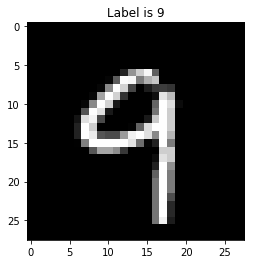

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.contrib.learn.datasets.load_dataset("mnist")  # 读取数据集，本地没有缓存就下载一个

train_data = mnist.train.images  # Returns np.ndarray
train_labels = mnist.train.labels  # Returns np.ndarray

image = train_data[8]
label = train_labels[8]

print('Shape is {shape}'.format(shape=image.shape))

plt.title('Label is {label}'.format(label=label))
plt.imshow(image.reshape([28, 28]), cmap='gray')
plt.show()

# 全连接神经网络

全连接是一种很直观的神经网络
![fcnn](./images/fc_nn.png)
我们先做一个这样的网络，它有三层全连接。

## 全连接层
我们知道每个神经元相当于一个函数，这里的神经元就是`f(x)=W * x + b`，这里的`W`和`b`就是需要学习的参数。
这里的第一个全连接层相当于把一个长度784的向量依次传入16个函数，那么能得到16个结果，那么有几个神经元，就会输出多少个值。如果还有下一层，这些输出的值就会作为输入，传给下一层的神经元。

上图输入层有784个输入，第二，三排各有16个神经元，第四层有10个神经元，代表10个数字，整个神经网络就是一个大方程，输入一个[784]形状的向量，输出一个[10]形状的向量。对输出的这10个数我们还可以做一个`softmax`，我们知道`max`函数是可以返回传入的参数中最大值，
`softmax`会计算出每个元素指数占所有元素的指数之和的比例，这是一个逻辑函数的扩展，用于多分类的逻辑回归。

![](./images/softmax.jpg)
------

![estimator](./images/estimator.png)
那么就使用Tensorflow的高级API`tf.estimator`包，搭建一个全连接的神经网络吧。

tensorflow中提供的卷积层api是`tf.layers.dense`, 密集连接层，和全连接是一个意思。

In [18]:
import tensorflow as tf


def dnn_model_fn(features, labels, mode):
    """
    用于构造estimator的model_fn
    :param features: 输入
    :param labels: 标签
    :param mode: 模式, 训练/验证/预测
    :return: EstimatorSpec
    """
    input_layer = features.get("input")   # 从字典中取到这次训练的图片，我们会拿到两张图，所以input_layer的形状是[2, 784]
    labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)  # 将标量的标签转成one-hot形式
    
    full_connect_layer_1 = tf.layers.dense(inputs=input_layer, units=16)  # 一个有16个神经元的全连接（密集连接）层
    full_connect_layer_2 = tf.layers.dense(inputs=full_connect_layer_1, units=16)  # 又一个有16个神经元的全连接层
    full_connect_layer_3 = tf.layers.dense(inputs=full_connect_layer_2, units=10)  #  包含10个神经元的全连接层
    
    softmax = tf.nn.softmax(full_connect_layer_3)  # 转换成概率
    
    predictions = {
        "classes": tf.argmax(input=softmax, axis=1),
        "probabilities": softmax
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=full_connect_layer_3)  # 损失函数，交叉熵，越小越好
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_or_create_global_step()
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(loss, global_step)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # 剩下就是eval，验证模式
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=tf.argmax(labels, 1),
                                        predictions=predictions['classes'],
                                        name='accuracy')
    }
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops=eval_metric_ops
    )

dnn_mnist_classifier = tf.estimator.Estimator(model_fn=dense_model_fn, model_dir="./dnn_mnist_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './mnist_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002733CB383C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
train_data = mnist.train.images  # 训练集
train_labels = mnist.train.labels
eval_data = mnist.test.images  # 验证集，用来验证模型的好坏
eval_labels = mnist.test.labels


#  使用estimator需要定义输入函数，这里tensorflow自带了一个
train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"input": train_data},  #  输入的图片
                y=train_labels,           #  对应的标签
                batch_size=2,             #  每次传入一张图片，同时传入多张图片做mini batch训练结果更好
                num_epochs=None,          #  将整个数据集循环几次
                shuffle=True              #  是否打乱顺序
            )

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"input": eval_data},
                    y=eval_labels,
                    num_epochs=1,
                    shuffle=False
                )  # 同上

In [25]:
dnn_mnist_classifier.train(input_fn=train_input_fn, steps=10000)  # 训练10000步就可以达到很好的效果, 几秒钟就可以训练好了
eval_results = dnn_mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_model\model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9001 into ./mnist_model\model.ckpt.
INFO:tensorflow:loss = 0.039568614, step = 9001
INFO:tensorflow:global_step/sec: 729.444
INFO:tensorflow:loss = 0.053829417, step = 9101 (0.138 sec)
INFO:tensorflow:global_step/sec: 1030.25
INFO:tensorflow:loss = 0.10309934, step = 9201 (0.097 sec)
INFO:tensorflow:global_step/sec: 960.903
INFO:tensorflow:loss = 0.038043384, step = 9301 (0.105 sec)
INFO:tensorflow:global_step/sec: 951.741
INFO:tensorflow:loss = 0.03310904, step = 9401 (0.104 sec)
INFO:tensorflow:global_step/sec: 1074.57
INFO:tensorflow:loss = 0.046363212, step = 9501 (0.093 sec)
INFO:tensorflow:global_step/sec: 933.965
INFO:tensorflow:loss = 0

# 卷积神经网络

一般来说想要识别数字9，要先看到它的上门有个圈，然后下面连一条线。

2d卷积神经网络就是将二维结构考虑了进去，上面的卷积示意图中可以看到，经过卷积核的运算得到的每个结果都是周围3\*3,9个像素共同参与运算得到。

我们训练出不同的卷积核来提取不同的特征，比如卷积核1号对圆圈敏感，卷积核2号对竖线敏感，那么数字9和数字2经过这两个卷积核得到的值肯定会有很大差别。

卷积层一般也有多层，可以根据输入的张量尺寸，选择不同层数。

靠前的卷积核可以提取低级特征，如圆圈的左上角圆弧，竖线的下半部分。

靠后的卷积核在前面的基础上，可以提取高级特征，比如可以判断是否有圆圈，是否有竖线。

**全连接是一个特殊的卷积，可以看作卷积核的形状和输入形状相同。**

tensorflow中提供的卷积层api是`tf.layers.conv2d`，同样使用`estimator`, 看看效果会提高多少吧。
我们的`input_fn`和上面的完全相同，所以就不在定义了。

In [34]:
def cnn_model_fn(features, labels, mode):
    input_layer = features.get("input")   # 从字典中取到这次训练的图片，我们会拿到两张图，所以input_layer的形状是[2, 784]
    labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)  # 将标量的标签转成one-hot形式
    input_layer = tf.reshape(input_layer, [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5], padding="same")
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], padding="same")
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, shape=[-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=10)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_or_create_global_step()
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(loss, global_step)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=tf.argmax(labels, 1),
                                        predictions=predictions['classes'],
                                        name='accuracy')
    }
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops=eval_metric_ops
    )

cnn_mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./cnn_mnist_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './cnn_mnist_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002733EBD8DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [35]:
cnn_mnist_classifier.train(input_fn=train_input_fn, steps=1000)  # 训练1000步就可以达到很好的效果, 都是由于计算比较复杂，所需时间长一些 
eval_results = cnn_mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./cnn_mnist_model\model.ckpt.
INFO:tensorflow:loss = 2.424192, step = 1
INFO:tensorflow:global_step/sec: 25.5455
INFO:tensorflow:loss = 1.0320555, step = 101 (3.917 sec)
INFO:tensorflow:global_step/sec: 25.3704
INFO:tensorflow:loss = 0.36364695, step = 201 (3.941 sec)
INFO:tensorflow:global_step/sec: 24.8592
INFO:tensorflow:loss = 0.021345321, step = 301 (4.024 sec)
INFO:tensorflow:global_step/sec: 26.0244
INFO:tensorflow:loss = 0.4292304, step = 401 (3.842 sec)
INFO:tensorflow:global_step/sec: 25.9232
INFO:tensorflow:loss = 0.21305872, step = 501 (3.859 sec)
INFO:tensorflow:global_step/sec: 25.8027
INFO:tensorflow:loss = 0.08759871, step = 601 (3.876 sec)
INFO:tensorflow:global_step/sec: 25.9299
INFO:tensor

# MNIST总结
上面的两个非常简单的模型就可以达到91%以上的准确率，可以说效果不错了，在cnn_model的基础上再修改一些，可以达到更好的准确率，

在卷积层增加激活函数`relu`，全连接层中间加入`dropout`层后，2000步的训练结果就很好了：

`{'accuracy': 0.9854, 'loss': 0.04469394, 'global_step': 2000}`

这里就不多说了。
模型可以在github下载，有兴趣可以试一下。

# 更复杂的图像识别
会涉及到很多不同的网络层，大多是卷积神经网络的扩展，由于比较复杂，只说一下它们的使用。

我们使用复杂的模型目的是要识别自己的图像，自己的类别，那么从网上下载来的模型是在其他类别上训练的，和我们的物品类别不同，这里有一个方法叫做迁移学习。

## 迁移学习

其实迁移学习在人类学习中是占了很大比重的，比如学习汉字，认识了一个偏旁，再看到某个字有这个偏旁，虽然不认识，也可以猜个大概。
机器学习的迁移学习中，底层网络可以提取低级的特征，就像刚才说的偏旁，那我们重做上层网络，保留下层已经训练好的参数，这就是迁移学习。

比如现在想做英文字母的识别，手头有英文字母的图像，但是图像非常少每样就几十张，直接训练很容易过拟合。cnn_mnist的模型，准确率已经很好了，那就可以借它的网络一用，假设字母图像也是单通道28\*28的图像，那我们基础网络不需要改变，只需把输出个数修改，并且从数字模型中恢复除了最后一层以外的训练好的参数并且固定住禁止训练，只有最后一层允许训练，这样的话结果会比直接拿字母数据集训练的结果更好。

# 复杂模型

## Inception_v3

Inception_v3是谷歌提出的一种神经网络。由于网络结构比较复杂，这里就介绍一下怎么迁移学习。
Inception_v3的网络最后三层是一个全连接层+一个Dropout层+一个全连接层。

```
dense = tf.layers.dense(inputs=net, units=1024, activation=tf.nn.relu)  # 这里的activation是激活函数，是一个非线性函数
dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))
predictions = tf.layers.dense(inputs=dropout, units=params.get("nb_classes"), name="predictions")  # 最后一层的输出数量就是类别个数
```

relu：修正线性单元（Rectified Linear Unit）
```
def relu(x):
    return max(0, x)  # 最常用的就是max
```

![relu](./images/sigmoid_and_relu.png)

我们修改这最后的一层或两层全连接层就能够完成迁移学习，因为低级特征被保存在卷积层中，我们迁移学习不会修改那些参数。

先看看修改最后一层的，我们可以在模型中写死

```
prediction = tf.layers.dense(inputs=dropout, units=42)  # 我有42个类别需要识别
```

也可以通过model_fn的第四个形参`params`,一个字典，传入units个数，这样model_fn不需要经常修改。

然后在返回训练模式的`EstimatorSpec`之前，从训练好的参数中加载参数，当然，这里需要注意，因为要重新训练最后一层，所以最后一层的参数不能加载，而是让Estimator去自动初始化。

```
exclude = ["predictions"]  # 最后一层的名字，因为需要训练新参数，所以这层要排除
# 这里使用了Tensorflow的一个高级API包slim，获取需要恢复的参数(变量)列表
variables_to_restore = tf.contrib.slim.get_variables_to_restore(exclude=exclude)
tf.train.init_from_checkpoint(params.get("checkpoint"), {v.name.split(':')[0]: v for v in variables_to_restore})  # 将checkpoint路径传入，第二个参数是变量名映射，checkpoint中的变量名和静态图中的变量名有差别。这个例子中差别在于变量名后面的 :0 标记。
```


那么一个迁移学习模型就做好了，再构造一个输入函数，将图片和对应的标签传入estimator就可以训练了，Tensorflow也提供了一个可视化工具**Tensorboard**可以在浏览器中方便地查看损失函数值变化趋势。